In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import swat.cas.datamsghandlers as dmh
from swat import *
import dlpy
from dlpy import Sequential
from dlpy.layers import * 
from dlpy.model import Optimizer, AdamSolver, Sequence
from dlpy.timeseries import plot_timeseries
from dlpy.metrics import accuracy_score, roc_auc_score, confusion_matrix
from getpass import getpass
%matplotlib inline

# Parameters

In [2]:
period = 30
seq_len = 50

# Python - Prepare Train Data

In [3]:
train = pd.read_csv('/sasdata/pdm/PM_train.txt',sep=' ')
train.drop(train.columns[[26,27]], axis=1, inplace=True)
train.shape

(20631, 26)

In [6]:
train['ttf'] = train.groupby(['id'])['cycle'].transform(max)-train['cycle']
train.shape

(20631, 27)

In [7]:
train['nearfailure'] = train['ttf'].apply(lambda x: 1 if x <= period else 0)
train['age'] = train['cycle']
train.shape

(20631, 29)

# Python - Prepare Test Data

In [4]:
test = pd.read_csv('/sasdata/pdm/PM_test.txt',sep=' ')
test.drop(test.columns[[26,27]], axis=1, inplace=True)
test.shape

(13096, 26)

In [5]:
more = pd.read_csv('/sasdata/pdm/PM_truth.txt',sep=' ')
more.drop(more.columns[1], axis=1, inplace=True)
more.columns = ['more']
more['id'] = more.index + 1
more.shape

(100, 2)

In [8]:
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.shape

(100, 2)

In [9]:
more['rtf'] = more['more'] + rul['max']
more.shape

(100, 3)

In [10]:
more.drop('more', axis=1, inplace=True)
test = test.merge(more,on=['id'],how='left')
test['ttf'] = test['rtf'] - test['cycle']
test.drop('rtf', axis=1, inplace=True)
test.shape

(13096, 27)

In [11]:
test['nearfailure'] = test['ttf'].apply(lambda x: 1 if x <= period else 0)
test['age'] = test['cycle']
test.shape

(13096, 29)

# Connect to SAS Viya

In [12]:
sas = CAS('localhost', 5570, 'sasdemo', getpass('Please enter your passwod:'))

Please enter your passwod:········


# Load Data

In [13]:
ts_train = dlpy.TimeseriesTable.from_pandas(sas, train)

In [14]:
ts_train.shape

(20631, 29)

# Preprocess Data

In [15]:
series = ts_train.columns.drop(['id','cycle','ttf']).values.tolist()

In [16]:
ts_train.timeseries_formatting(timeid='cycle',
                               timeseries=series)

NOTE: Timeseries formatting is completed.


In [17]:
ts_train.timeseries_accumlation(acc_interval='obs',
                                groupby='id')

NOTE: Added action set 'timeData'.
NOTE: Timeseries are accumulated to the frequency of obs


In [18]:
ts_train.prepare_subsequences(seq_len=seq_len, 
                              target='nearfailure', 
                              predictor_timeseries=series)

NOTE: timeseries subsequences are prepared with subsequence length = 50


In [19]:
ts_train.shape

(15631, 1305)

# Model 1

NOTE: Input layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


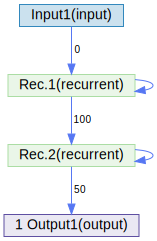

In [20]:
model = Sequential(sas, model_table='lstm_rnn')

model.add(InputLayer(std='STD'))
model.add(Recurrent(rnn_type='LSTM', output_type='samelength', n=100, dropout=0.1, act='sigmoid'))
model.add(Recurrent(rnn_type='LSTM', output_type='encoding',  n=50, dropout=0.1, act='sigmoid'))
model.add(OutputLayer(n=1, full_connect=True, act='sigmoid', error='entropy'))

model.plot_network()

In [48]:
optimizer = Optimizer(algorithm=AdamSolver(), 
                      max_epochs=100, 
                      mini_batch_size=200,
                      seed=1234)

In [49]:
seq_spec  = Sequence(**ts_train.sequence_opt)

In [53]:
result = model.train(ts_train, 
                     optimizer=optimizer,
                     sequence=seq_spec, 
                     **ts_train.inputs_target,
                     model='lstm_rnn',
                     model_weights=sas.CASTable('rnn_weights', replace=True))

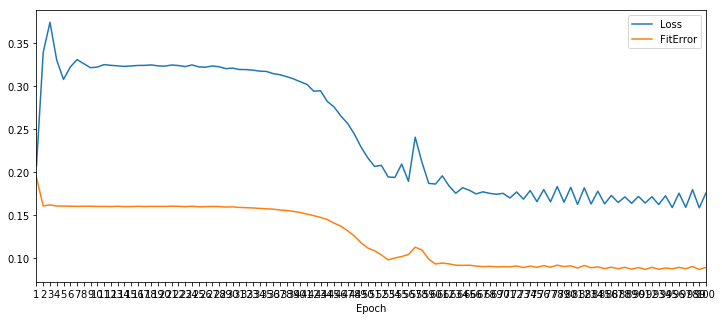

In [54]:
model.plot_training_history(tick_frequency=1)

In [55]:
result

,Descr,Value
0,Model Name,lstm_rnn
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,80900


# Model 2

In [25]:
name = 'lstm_002'

NOTE: Input layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


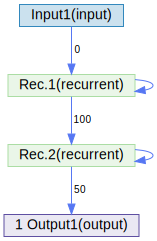

In [26]:
model = Sequential(sas, model_table=name)

model.add(InputLayer(std='STD'))
model.add(Recurrent(rnn_type='LSTM', output_type='samelength', n=100, dropout=0.1, act='tanh'))
model.add(Recurrent(rnn_type='LSTM', output_type='encoding',  n=50, dropout=0.1, act='tanh'))
model.add(OutputLayer(n=1, full_connect=True, act='sigmoid', error='entropy'))

model.plot_network()

In [27]:
optimizer = Optimizer(algorithm=AdamSolver(), 
                      max_epochs=100, 
                      mini_batch_size=200,
                      seed=1234)

In [28]:
seq_spec  = Sequence(**ts_train.sequence_opt)

In [29]:
result = model.train(ts_train, 
                     optimizer=optimizer,
                     sequence=seq_spec, 
                     **ts_train.inputs_target,
                     model=name,
                     model_weights=name+'_weights')

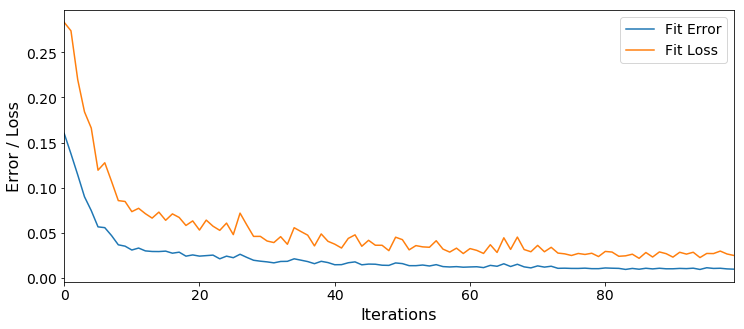

In [89]:
# model.plot_training_history(tick_frequency=1)
result.OptIterHistory[['FitError', 'Loss']][0:].plot(figsize=(12,5))
ax = plt.gca()
ax.get_xaxis().set_tick_params(labelsize=14)
ax.get_yaxis().set_tick_params(labelsize=14)
ax.legend(['Fit Error', 'Fit Loss'], loc='upper right', prop={'size': 14})
ax.set_xlabel('Iterations',fontsize=16)
ax.set_ylabel('Error / Loss',fontsize=16)
plt.show()

In [32]:
result

,Descr,Value
0,Model Name,lstm_002
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,80900


# Evaluate

In [34]:
ts_test = dlpy.TimeseriesTable.from_pandas(sas, test)

In [35]:
ts_test.shape

(13096, 29)

In [36]:
ts_test.timeseries_formatting(timeid='cycle',
                               timeseries=series)

NOTE: Timeseries formatting is completed.


In [37]:
ts_test.timeseries_accumlation(acc_interval='obs',
                                groupby='id')

NOTE: Added action set 'timeData'.
NOTE: Timeseries are accumulated to the frequency of obs


In [38]:
ts_test.prepare_subsequences(seq_len=seq_len, 
                              target='nearfailure', 
                              predictor_timeseries=series)

NOTE: timeseries subsequences are prepared with subsequence length = 50


In [39]:
ts_test.shape

(8162, 1305)

In [40]:
model.score(ts_test,
            model=name,
            init_weights=name+'_weights', 
            copy_vars=['id','cycle','nearfailure'],
            casout=dict(name='lstm_pred', replace=True))

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          8162
 1  Number of Observations Used          8162
 2           Mean Squared Error      0.004621
 3                   Loss Error      0.015162

[OutputCasTables]

              casLib       Name  Rows  Columns  \
 0  CASUSER(sasdemo)  lstm_pred  8162        4   
 
                                            casTable  
 0  CASTable('lstm_pred', caslib='CASUSER(sasdemo)')  

+ Elapsed: 2.36s, user: 13.2s, sys: 0.043s, mem: 41.1mb

In [59]:
pred = sas.CASTable('lstm_pred')

In [60]:
sas.loadactionset('fedSql')

NOTE: Added action set 'fedSql'.


[actionset]

 'fedSql'

+ Elapsed: 0.0353s, user: 0.004s, mem: 0.23mb

In [65]:
sas.fedsql.execdirect('create table lstm_pred {options replace=true} as select '
                      '   *, '
                      '   case when _DL_Pred_ < 0.5 then 0 else 1 end as nf_pred '
                      'from lstm_pred')

NOTE: Table LSTM_PRED was created in caslib CASUSER(sasdemo) with 8162 rows returned.


+ Elapsed: 0.105s, user: 0.033s, sys: 0.028s, mem: 26.8mb

In [79]:
acc = accuracy_score(ts_test.nearfailure, pred.nf_pred, id_vars='id')
auc = roc_auc_score(ts_test.nearfailure, pred._DL_Pred_, id_vars='id', pos_label=1)
cmx = confusion_matrix(ts_test.nearfailure, pred.nf_pred, id_vars='id', labels=[0,1])

In [80]:
print('Accuracy Score: %.4f' % acc)
print('AUC Score: %.4f' % auc)
print('\nConfusion Matrix:\n%s' % cmx)

Accuracy Score: 0.9944
AUC Score: 0.9974

Confusion Matrix:
nf_pred           0      1
nearfailure               
0            7828.0    2.0
1              44.0  288.0


# Save Model

In [94]:
model.save_to_table('/sasdata/pdm')

NOTE: Model table saved successfully.
